In [127]:
import yfinance as yf
import numpy as np
import pandas as pd
import cvxpy as cp

tickers = [
    "AAPL", "NVDA", "MSFT", "AMZN", "GOOGL", "GOOG", "META", "^SPX", "AVGO", "TSLA",
    "LLY", "WMT", "JPM", "V", "XOM", "MA", "UNH", "ORCL", "COST", "PG",
    "NFLX", "JNJ", "ABBV", "HD", "BAC", "KO", "TMUS", "CVX", "CRM", "CSCO",
    "MRK", "PM", "WFC", "IBM", "ABT", "LIN", "MCD", "GE", "PEP", "PLTR",
    "ACN", "TMO", "T", "AXP", "MS", "VZ", "DIS", "GS", "RTX", "NOW",
    "QCOM", "ISRG", "ADBE", "BX", "AMGN", "INTU", "PGR", "AMD", "CAT", "TXN",
    "DHR", "NEE", "UBER", "SPGI", "BKNG", "PFE", "BLK", "BSX", "UNP", "SYK",
    "SCHW", "GILD", "HON", "CMCSA", "VRTX", "C", "DE", "TJX", "AMAT", "COP",
    "LOW", "BA", "PANW", "FI", "MDT", "BMY", "ADP", "CB", "ETN", "MMC",
    "MU", "SBUX", "LMT", "NKE", "PLD", "ANET", "INTC", "ADI", "LRCX", "KKR"
]


In [128]:
inc = yf.download(tickers, period='2y')
t = yf.download(tickers= '^TYX', period='2y')

[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  1 of 1 completed


In [129]:
inc = inc['Close']
t = t['Close']


In [130]:
rets = np.log(inc / inc.shift(1))
t = t/365
rets.drop('2023-03-15', inplace = True)
t.drop('2023-03-15', inplace = True)
t.drop('2023-03-14', inplace = True)
t = t.reset_index()
rets = rets.reset_index()
rets = rets[rets.index < 365]
rf_rate =t[t.index < 365]['^TYX'].values

In [131]:
excess_returns = rets.merge(t, on = 'Date')
rets.drop(['Date'], axis = 1, inplace = True)

excess_returns.iloc[:, 1:-1] = excess_returns.iloc[:, 1:-1].sub(excess_returns["^TYX"], axis=0)

In [132]:
excess_returns.drop(['^TYX', 'Date'], axis = 1, inplace= True)

In [133]:
cov_matrix = rets.cov().values * 252

In [134]:
mu = rets.mean(axis=0).values.reshape(-1, 1)
num_assets = rets.shape[1]
weights = cp.Variable(num_assets)

In [135]:
target_return = cp.Parameter()

portfolio_return = mu.T @ weights
portfolio_variance = cp.quad_form(weights, cov_matrix)

problem = cp.Problem(
    cp.Minimize(portfolio_variance),
    [portfolio_return >= target_return, cp.sum(weights) == 1, weights >= 0]
)

In [136]:
import numpy as np

target_returns = np.linspace(mu.min(), mu.max(), 50)
efficient_portfolios = []

for ret in target_returns:
    target_return.value = ret
    problem.solve()
    efficient_portfolios.append({
        'return': ret,
        'volatility': np.sqrt(portfolio_variance.value),
        'weights': weights.value
    })

array([0.01017534, 0.00985753, 0.01003562, 0.01023836, 0.01013151,
       0.01008767, 0.00998356, 0.01030137, 0.01036438, 0.01035069,
       0.01026301, 0.01010685, 0.00998356, 0.00984658, 0.00974795,
       0.00969863, 0.00993425, 0.00992055, 0.01000822, 0.01010137,
       0.01024384, 0.01042466, 0.01037534, 0.01038082, 0.01028219,
       0.01035069, 0.0102137 , 0.01000274, 0.01010685, 0.01029041,
       0.01007671, 0.01046027, 0.0102274 , 0.01017808, 0.0102    ,
       0.01030685, 0.01050685, 0.01054247, 0.01040822, 0.01026849,
       0.01034795, 0.01052603, 0.01060548, 0.01062466, 0.01068767,
       0.01081644, 0.01087671, 0.01082466, 0.01086301, 0.01096712,
       0.01087397, 0.01069315, 0.01056438, 0.01050137, 0.01063562,
       0.01065753, 0.0106137 , 0.0108    , 0.01063562, 0.01064932,
       0.01070411, 0.01079726, 0.01063288, 0.01054247, 0.01056164,
       0.01046027, 0.01043288, 0.01060822, 0.01046849, 0.01046301,
       0.01052055, 0.01041918, 0.01072055, 0.01056164, 0.01060

In [142]:
sharpe_ratios = [(p['return'] - rf_rate.mean()) / p['volatility'] for p in efficient_portfolios]
tangency_portfolio = efficient_portfolios[np.argmax(sharpe_ratios)]

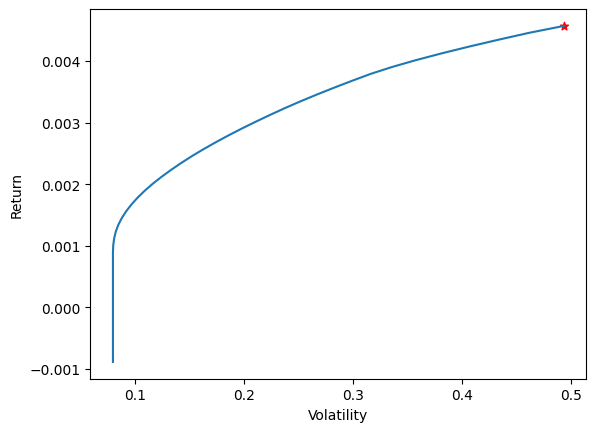

In [143]:
import matplotlib.pyplot as plt

plt.plot([p['volatility'] for p in efficient_portfolios], [p['return'] for p in efficient_portfolios])
plt.scatter(tangency_portfolio['volatility'], tangency_portfolio['return'], color='red', marker='*')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()